In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy as sp
from scipy.linalg import toeplitz, matmul_toeplitz
from PIL import Image

In [2]:
def image_to_array(image_path):

    img = Image.open(image_path).convert('L')

    threshold = 128
    binary_img = img.point(lambda x: 0 if x > threshold else 1, '1')
    
    array = np.array(binary_img, dtype=int)
    
    return array

In [3]:
def array_to_image(array, output_file=None):

    if not isinstance(array, np.ndarray):
        raise ValueError("Input must be a numpy array.")

    if array.ndim != 2:
        raise ValueError("Input array must be 2D.")

    normalized_array = 255 - (255 * (array - array.min()) / (np.ptp(array) + 1e-8)).astype(np.uint8)

    image = Image.fromarray(normalized_array, mode='L')

    if output_file:
        image.save(output_file)

    return image

In [4]:
def normalize(p):
    return p / np.sum(p)

In [5]:
def applyK(v, N_grid, Gamma):
    V = np.zeros(N_grid * N_grid)
    u = np.zeros((N_grid, N_grid))
    
    for i in range(N_grid):
        for j in range(i, N_grid):
            u[i, j] = (i - j) ** 2

    U = np.copy(u) + np.copy(u).T

    for i in range(N_grid):
        for j in range(N_grid):
            V[(i*N_grid):((i+1)*N_grid)] += np.exp(-(U + (i - j) ** 2) / Gamma) @ v[(j*N_grid):((j+1)*N_grid)]
    
    return V

In [6]:
def sinkhorn_barycenter(Lambda, p, L, N_grid, Gamma):

    S = len(p)
    N_histo = N_grid * N_grid
    a = np.ones((N_histo, S))
    b = np.ones((N_histo, S))

    for _ in range(L):
        P = np.ones(N_histo)
        for k in range(S):
            P *= applyK(a[:, k], N_grid, Gamma) ** Lambda[k]

        for k in range(S):
            b[:, k] = np.copy(P) / applyK(a[:, k], N_grid, Gamma)

        for k in range(S):
            a[:, k] = np.copy(p[k, :]) / applyK(b[:, k], N_grid, Gamma)

    P = np.ones(N_histo)
    for k in range(S):
        P *= applyK(a[:, k], N_grid, Gamma) ** Lambda[k]

    return P

In [7]:
shape1 = normalize(image_to_array("cercle.png").reshape(-1))
shape2 = normalize(image_to_array("triangle.png").reshape(-1))
shape3 = normalize(image_to_array("carre.png").reshape(-1))

shapes = np.array([shape1, shape2, shape3])

In [8]:
Lambda = np.array([0.34, 0.33, 0.33])
SHAPE = sinkhorn_barycenter(Lambda, shapes, 12, 100, 8)

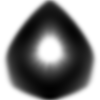

In [9]:
array_to_image(SHAPE.reshape((100, 100)), output_file="APPLICATION 1.jpg")

In [13]:
def sinkhorn_differentiate(Lambda, p, q, L, N_grid, Gamma):

    S = len(p)
    N_histo = N_grid * N_grid
    Phi = np.ones((L+1, N_histo, S))
    b = np.ones((L+1, N_histo, S))
    w = np.zeros(S)
    r = np.zeros((N_histo, S))
    
    for i in range(1, L+1):
        P = np.ones(N_histo)
        
        for j in range(S):
            Phi[i, :, j] = applyK(p[j, :] / (applyK(b[i-1, :, j], N_grid, Gamma)), N_grid, Gamma)

        for j in range(S):
            P *= Phi[i, :, j] ** Lambda[j]

        for j in range(S):
            b[i, :, j] = P / Phi[i, :, j]

    g = (P - q) * P

    for i in range(1, L+1):
        
        for j in range(S):
            w[j] += np.dot(np.log(Phi[L-i+1, :, j]), g)

        for j in range(S):
            r[:, j] = - applyK(applyK((Lambda[j] * g - r[:, j]) / Phi[L-i+1, :, j], N_grid, Gamma) * (p[j, :] / (applyK(b[L-i, :, j], N_grid, Gamma) ** 2)), N_grid, Gamma) * b[L-i, :, j]

        g = np.zeros(N_histo)
        for j in range(S):
            g += r[:, j]

    return np.sum((P - q) ** 2), w

In [42]:
shape0 = normalize(image_to_array("penta.png").reshape(-1))

In [43]:
resX = sp.optimize.minimize(sinkhorn_differentiate, Lambda, bounds=((0, 1), (0, 1), (0, 1)), args=(shapes, shape0, 8, 100, 8), jac=True)

In [44]:
LambdaX = normalize(resX.x)
print(LambdaX)
PX = sinkhorn_barycenter(LambdaX, shapes, 16, 100, 8)

[0.57390262 0.23109489 0.19500249]


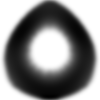

In [45]:
array_to_image(PX.reshape((100, 100)), output_file="APPLICATION 1 PENTA.jpg")

In [10]:
def chrominance_luminance_histograms(image_path):

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image at path '{image_path}' not found.")

    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    Y, Cr, Cb = cv2.split(ycrcb_image)

    hist_Y = cv2.calcHist([Y], [0], None, [64], [0, 256])
    hist_CrCb = cv2.calcHist([Cr, Cb], [0, 1], None, [64, 64], [0, 256, 0, 256])

    return hist_CrCb.reshape(-1), hist_Y.reshape(-1)

In [11]:
def image_to_chrominance_luminance_array(image_path):

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image at path: {image_path}")

    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    Y, Cb, Cr = cv2.split(ycrcb_image)

    chrominance_luminance_array = np.dstack((Y // 4, Cr // 4, Cb // 4))

    return chrominance_luminance_array

In [12]:
def ycbcr_to_rgb(ycbcr_array, output_path=None):

    ycbcr_array = np.array(ycbcr_array, dtype=np.uint8)
    
    ycbcr_image = Image.fromarray(ycbcr_array, mode="YCbCr")
    
    rgb_image = ycbcr_image.convert("RGB")

    rgb_image.save(output_path)

In [14]:
LambdaINI = np.array([0.3, 0.4, 0.3])

pA1, lA1 = chrominance_luminance_histograms("ALPES_data1.PNG")
pA2, lA2 = chrominance_luminance_histograms("ALPES_data2.jpeg")
pA3, lA3 = chrominance_luminance_histograms("ALPES_data3.jpg")
qA, LA = chrominance_luminance_histograms("ALPES_obj_200.jpg")
pA = np.array([normalize(pA1), normalize(pA2), normalize(pA3)])

pC1, lC1 = chrominance_luminance_histograms("CANYON_data1.jpg")
pC2, lC2 = chrominance_luminance_histograms("CANYON_data2.jpg")
pC3, lC3 = chrominance_luminance_histograms("CANYON_data3.PNG")
qC, LC = chrominance_luminance_histograms("CANYON_obj_200.jpg")
pC = np.array([normalize(pC1), normalize(pC2), normalize(pC3)])

pH1, lH1 = chrominance_luminance_histograms("HOGGAR_data1.jpg")
pH2, lH2 = chrominance_luminance_histograms("HOGGAR_data2.jpg")
pH3, lH3 = chrominance_luminance_histograms("HOGGAR_data3.jpg")
qH, LH = chrominance_luminance_histograms("HOGGAR_obj_200.jpg")
pH = np.array([normalize(pH1), normalize(pH2), normalize(pH3)])

In [17]:
resA = sp.optimize.minimize(sinkhorn_differentiate, LambdaINI, bounds=((0, 1), (0, 1), (0, 1)), args=(pA, normalize(qA), 8, 64, 8), jac=True)
print("A done")
resC = sp.optimize.minimize(sinkhorn_differentiate, LambdaINI, bounds=((0, 1), (0, 1), (0, 1)), args=(pC, normalize(qC), 8, 64, 8), jac=True)
print("C done")
resH = sp.optimize.minimize(sinkhorn_differentiate, LambdaINI, bounds=((0, 1), (0, 1), (0, 1)), args=(pH, normalize(qH), 8, 64, 8), jac=True)
print("H done")

A done


/tmp/ipykernel_6678/211707266.py:22: RuntimeWarning: overflow encountered in multiply
  g = (P - q) * P
/tmp/ipykernel_6678/2042652274.py:13: RuntimeWarning: invalid value encountered in matmul
  V[(i*N_grid):((i+1)*N_grid)] += np.exp(-(U + (i - j) ** 2) / Gamma) @ v[(j*N_grid):((j+1)*N_grid)]
/tmp/ipykernel_6678/211707266.py:30: RuntimeWarning: invalid value encountered in multiply
  r[:, j] = - applyK(applyK((Lambda[j] * g - r[:, j]) / Phi[L-i+1, :, j], N_grid, Gamma) * (p[j, :] / (applyK(b[L-i, :, j], N_grid, Gamma) ** 2)), N_grid, Gamma) * b[L-i, :, j]
/tmp/ipykernel_6678/211707266.py:36: RuntimeWarning: overflow encountered in square
  return np.sum((P - q) ** 2), w


C done
H done


In [18]:
LambdaA = normalize(resA.x)
LambdaC = normalize(resC.x)
LambdaH = normalize(resH.x)

In [46]:
print(LambdaA)
print(LambdaC)
print(LambdaH)

[0.20762698 0.20938447 0.58298855]
[0.35276515 0.34822296 0.29901189]
[0.39944724 0.         0.60055276]


In [23]:
PA = sinkhorn_barycenter(LambdaA, pA, 16, 64, 8)
PC = sinkhorn_barycenter(LambdaC, pC, 16, 64, 8)
PH = sinkhorn_barycenter(LambdaH, pH, 16, 64, 8)

In [24]:
def sinkhorn_algorithm(p, q, L, N_grid, Gamma):

    N_histo = N_grid * N_grid
    u = np.ones(N_histo)
    v = np.ones(N_histo)

    for _ in range(L):

        u = p / applyK(v, N_grid, Gamma)
        v = q / applyK(u, N_grid, Gamma)

    return u, v

In [25]:
def transport_pixel(x, u, v, N_grid, Gamma):

    N_histo = N_grid * N_grid
    w = np.zeros(N_histo)
    w[int(x[0]) + int(x[1]) * N_grid] = u[int(x[0]) + int(x[1]) * N_grid]

    T = applyK(w, N_grid, Gamma) * v
    M = int(np.round(np.sum((-T).argsort()[:4])/4))
    
    return (M % N_grid, M // N_grid)

In [28]:
def transport_image(P, q, image_path, L, N_grid, Gamma, output_file='output_image.png'):

    W = image_to_chrominance_luminance_array(image_path)
    U, V = sinkhorn_algorithm(P, q, L, N_grid, Gamma)

    for i in range(len(W)):
        if i%25 == 0 and i !=0 :
            print("25 lines done")
        for j in range(len(W[0])):
            W[i, j, 1], W[i, j, 2] = transport_pixel([W[i, j, 1], W[i, j, 2]], U, V, N_grid, Gamma)
            W[i, j] *= 4

    ycbcr_to_rgb(W, output_file)

In [29]:
transport_image(PA, normalize(qA), "ALPES_obj_200.jpg", 16, 64, 8, output_file='ALPES_modified.png')

25 lines done
25 lines done
25 lines done


In [30]:
transport_image(PC, normalize(qC), "CANYON_obj_200.jpg", 16, 64, 8, output_file='CANYON_modified.png')

25 lines done
25 lines done
25 lines done
25 lines done
25 lines done


In [31]:
transport_image(PH, normalize(qH), "HOGGAR_obj_200.jpg", 16, 64, 8, output_file='HOGGAR_modified.png')

25 lines done
25 lines done
25 lines done
25 lines done
